In [16]:
from google.colab import drive
import os
drive.mount('/content/drive')

!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

# Change the current working directory to MyDrive/DLPJ
os.chdir('/content/drive/MyDrive/DLPJ/src')

# Verify the current working directory
print(f"Current working directory: {os.getcwd()}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Looking in indexes: https://download.pytorch.org/whl/cu118
Current working directory: /content/drive/MyDrive/DLPJ/src


In [17]:
import json
import numpy as np
import torch
import random
import pandas as pd

from msstud_spiel_shim import MsStudSpielGame
from msstud_kisenwether_strategy import kisenwether_policy
from dqn_agent import DQNAgent
from dueling_dqn_agent import DuelingDQNAgent
from distributional_dqn_agent import DistributionalDQNAgent
from ppo_agent import PPOAgent
from gpu_utils import get_device
from letitride_env import LetItRideEnv
from math import erf, sqrt

from dataclasses import dataclass
from typing import List, Tuple, Optional

# We want the same obs length as MsStudSpielState: 4 (round one-hot) + 13 (ranks) + 4 (suits) = 21

class LetItRideSpielGame:
    def __init__(self, ante: int = 1, seed: Optional[int] = None):
        self._ante = ante
        self._seed = seed
        self._rng = random.Random(seed)

    def new_initial_state(self):
        hand_seed = self._rng.randint(0, 2**32 - 1)
        return LetItRideSpielState(self._ante, hand_seed)

    def num_players(self) -> int:
        return 1

    def __str__(self):
        return f"LetItRideSpielGame(ante={self._ante})"


@dataclass
class LetItRideSpielState:
    ante: int = 1
    seed: Optional[int] = None

    def __post_init__(self):
        # Underlying env
        self._env = LetItRideEnv(ante=self.ante, seed=self.seed)
        self._state = self._env.reset()
        self._player = 0
        self._is_chance = False

    # ---- Core OpenSpiel-like API ----
    def current_player(self) -> int:
        if self.is_terminal():
            return -2
        return self._player

    def is_chance_node(self) -> bool:
        return self._is_chance

    def chance_outcomes(self) -> List[Tuple[int, float]]:
        return []

    def legal_actions(self, player: Optional[int] = None) -> List[int]:
        if self.is_terminal():
            return []
        return self._env.legal_actions()

    def apply_action(self, action: int) -> None:
        if self.is_terminal():
            return
        self._state = self._env.step(action)

    def child(self, action: int) -> "LetItRideSpielState":
        import copy
        nxt = copy.deepcopy(self)
        nxt.apply_action(action)
        return nxt

    # ---- Episode status & return ----
    def is_terminal(self) -> bool:
        return self._state.terminal

    def returns(self) -> List[float]:
        return [self._state.last_reward if self.is_terminal() else 0.0]

    # ---- Observations / info ----
    def observation_string(self, player: int = 0) -> str:
        o = self._env.observation()
        hole = "-".join(sorted(o["hole"]))
        comm = "-".join(sorted(o["community"]))
        bets = ",".join("1" if b else "0" for b in o["active_bets"])
        return f"r{o['round']}|h:{hole}|c:{comm}|b:{bets}"

    def information_state_string(self, player: int = 0) -> str:
        return self.observation_string(player)

    def observation_tensor(self, player: int = 0) -> List[float]:
        """
        Mirror MsStudSpielState.observation_tensor structure:
        - round one-hot (4)
        - ranks histogram (13)
        - suits histogram (4)
        Total = 21, matching the Mississippi Stud models.
        """
        o = self._env.observation()
        rnd = [0.0] * 4
        rnd[o["round"]] = 1.0

        ranks = [0.0] * 13
        suits = {"C": 0.0, "D": 0.0, "H": 0.0, "S": 0.0}

        def rank_int(cs):
            r = cs[0]
            return "23456789TJQKA".index(r)

        # Only use visible cards (hole + revealed community) like MsStud
        for cs in o["hole"] + o["community"]:
            ranks[rank_int(cs)] += 1.0
            suits[cs[1]] += 1.0

        return rnd + ranks + [suits["C"], suits["D"], suits["H"], suits["S"]]

    # ---- Debug helper ----
    def history_str(self) -> str:
        o = self._env.observation()
        return (
            f"round={o['round']} | hole={o['hole']} | comm={o['community']} "
            f"| active_bets={o['active_bets']} | terminal={o['terminal']} "
            f"| last_reward={o['last_reward']}"
        )

device = get_device()
print("Using device:", device)

os.makedirs("weights_ms", exist_ok=True)
os.makedirs("weights_lir", exist_ok=True)


Using GPU: NVIDIA A100-SXM4-40GB
CUDA version: 12.6
GPU memory: 42.5 GB
Using device: cuda


In [18]:
def run_policy_ms(game, policy_fn, num_hands=10000):
    """
    Evaluate a policy on Mississippi Stud:
    returns: (EV, house_edge, avg_bet, element_of_risk, unique_hands, std_dev)
    """
    returns = []
    total_bet = 0.0
    hands_seen = set()

    for _ in range(num_hands):
        state = game.new_initial_state()

        # Identify full 5-card hand (hole + community + friends if any)
        o = state._env.observation()
        full_hand = o["hole"] + o["community"]
        full_hand += o.get("friends_cards", [])
        hand_tuple = tuple(sorted(full_hand))
        hands_seen.add(hand_tuple)

        hand_bet = 1.0  # ante
        while not state.is_terminal():
            action = policy_fn(state)
            # In your env, actions 1,2,3 add bets
            if action in [1, 2, 3]:
                hand_bet += action
            state.apply_action(action)

        r = state.returns()[0]
        returns.append(r)
        total_bet += hand_bet

    returns = np.array(returns, dtype=float)
    avg_ev = float(returns.mean())
    std_dev = float(returns.std())
    house_edge = -avg_ev / 1.0 * 100.0
    avg_bet = total_bet / num_hands
    element_of_risk = house_edge / avg_bet if avg_bet > 0 else 0.0
    unique_hands = len(hands_seen)
    return avg_ev, house_edge, avg_bet, element_of_risk, unique_hands, std_dev


def run_policy_lir(game, policy_fn, num_hands=10000):
    """
    Evaluate a policy on Let It Ride:
    returns: (EV, house_edge, avg_bet, element_of_risk, unique_hands, std_dev)
    """
    returns = []
    total_bet = 0.0
    hands_seen = set()

    for _ in range(num_hands):
        state = game.new_initial_state()

        # For uniqueness: hole + both community cards (peek at env)
        o0 = state._env.observation()
        hidden = state._env.state.hidden_community
        full_hand = o0["hole"] + hidden
        hand_tuple = tuple(sorted(full_hand))
        hands_seen.add(hand_tuple)

        while not state.is_terminal():
            action = policy_fn(state)
            state.apply_action(action)

        r = state.returns()[0]
        returns.append(r)

        of = state._env.observation()
        hand_bet = sum(of["active_bets"]) * state.ante
        total_bet += hand_bet

    returns = np.array(returns, dtype=float)
    avg_ev = float(returns.mean())
    std_dev = float(returns.std())
    house_edge = -avg_ev / 1.0 * 100.0
    avg_bet = total_bet / num_hands
    element_of_risk = house_edge / avg_bet if avg_bet > 0 else 0.0
    unique_hands = len(hands_seen)
    return avg_ev, house_edge, avg_bet, element_of_risk, unique_hands, std_dev


In [19]:
def evaluate_agent_from_weights(
    label,
    AgentClass,
    make_game_fn,
    run_policy_fn,
    weight_path,
    agent_kwargs,
    num_hands=10000,
):
    """
    Instantiate agent, load weights, and evaluate on the given game.
    Returns: (label, metrics_tuple)
    metrics_tuple = (EV, house_edge, avg_bet, element_of_risk, unique_hands, std_dev)
    """
    game_for_agent = make_game_fn()
    agent = AgentClass(game_for_agent, **agent_kwargs)

    # Load weights
    state_dict = torch.load(weight_path, map_location=device)
    agent.model.load_state_dict(state_dict)

    # Sync target network if exists
    if hasattr(agent, "update_target"):
        agent.update_target()

    # Evaluate
    eval_game = make_game_fn()
    metrics = run_policy_fn(eval_game, agent.policy, num_hands=num_hands)
    print(f"{label}: EV={metrics[0]:.5f}, HE={metrics[1]:.2f}%, AvgBet={metrics[2]:.2f}, Std={metrics[5]:.2f}")
    return label, metrics


In [20]:
def evaluate_ms_from_weights(num_hands=10000):
    results = {}

    # Factory for fresh MS Stud game
    make_ms_game = lambda: MsStudSpielGame(ante=1, seed=None, friends=0)

    # 1) Kisenwether baseline (no weights)
    print("\n=== Kisenwether Strategy (MS) ===")
    k_metrics = run_policy_ms(make_ms_game(), kisenwether_policy, num_hands=num_hands)
    print(f"Kisenwether: EV={k_metrics[0]:.5f}, HE={k_metrics[1]:.2f}%, AvgBet={k_metrics[2]:.2f}, Std={k_metrics[5]:.2f}")
    results["kisenwether"] = list(k_metrics)

    # Common DQN-like kwargs (match what you used during training)
    dqn_kwargs = dict(
        lr=1e-4,
        gamma=1.0,
        epsilon=0.95,
        min_epsilon=0.005,
        epsilon_decay=0.9999,
        batch_size=128,
        double_dqn=True,
    )

    dist_kwargs = dict(
        lr=1e-4,
        gamma=0.99,
        epsilon=0.95,
        min_epsilon=0.005,
        epsilon_decay=0.9999,
        batch_size=128,
        atom_size=51,
        v_min=-10,
        v_max=10,
    )

    ppo_kwargs = dict(
        lr=1e-4,
        gamma=1.0,
        clip=0.2,
        batch_size=128,
    )

    # 2) DQN
    lbl, metrics = evaluate_agent_from_weights(
        "DQN (MS)",
        DQNAgent,
        make_ms_game,
        run_policy_ms,
        "weights_ms/dqn_ms_lowlr.pth",
        dqn_kwargs,
        num_hands=num_hands,
    )
    results["dqn_ms"] = list(metrics)

    # 3) Dueling DQN
    lbl, metrics = evaluate_agent_from_weights(
        "Dueling DQN (MS)",
        DuelingDQNAgent,
        make_ms_game,
        run_policy_ms,
        "weights_ms/dueling_ms_lowlr.pth",
        dqn_kwargs,
        num_hands=num_hands,
    )
    results["dueling_ms"] = list(metrics)

    # 4) Distributional DQN
    lbl, metrics = evaluate_agent_from_weights(
        "Distributional DQN (MS)",
        DistributionalDQNAgent,
        make_ms_game,
        run_policy_ms,
        "weights_ms/distdqn_ms_lowlr.pth",
        dist_kwargs,
        num_hands=num_hands,
    )
    results["distdqn_ms"] = list(metrics)

    # 5) PPO
    print("\n=== PPO (MS) ===")
    make_ms_game_ppo = make_ms_game
    game_for_ppo = make_ms_game_ppo()
    ppo_agent = PPOAgent(game_for_ppo, **ppo_kwargs)

    ppo_state = torch.load("weights_ms/ppo_ms_lowlr.pth", map_location=device)
    ppo_agent.model.load_state_dict(ppo_state)

    eval_game = make_ms_game_ppo()
    ppo_metrics = run_policy_ms(eval_game, ppo_agent.policy, num_hands=num_hands)
    print(f"PPO (MS): EV={ppo_metrics[0]:.5f}, HE={ppo_metrics[1]:.2f}%, AvgBet={ppo_metrics[2]:.2f}, Std={ppo_metrics[5]:.2f}")
    results["ppo_ms"] = list(ppo_metrics)

    return results

# Run and save
ms_results = evaluate_ms_from_weights(num_hands=10000)
with open("stat_results_ms_eval.json", "w") as f:
    json.dump(ms_results, f, indent=2, default=float)

print("\nSaved MS eval-only results to results_ms_eval.json")



=== Kisenwether Strategy (MS) ===
Kisenwether: EV=-0.22530, HE=22.53%, AvgBet=3.60, Std=5.99
Using GPU: NVIDIA A100-SXM4-40GB
CUDA version: 12.6
GPU memory: 42.5 GB
DQN (MS): EV=-0.70970, HE=70.97%, AvgBet=2.17, Std=5.58
Using GPU: NVIDIA A100-SXM4-40GB
CUDA version: 12.6
GPU memory: 42.5 GB
Dueling DQN (MS): EV=-0.64950, HE=64.95%, AvgBet=2.12, Std=4.26
Distributional DQN (MS): EV=-1.18910, HE=118.91%, AvgBet=3.88, Std=5.89

=== PPO (MS) ===
Using GPU: NVIDIA A100-SXM4-40GB
CUDA version: 12.6
GPU memory: 42.5 GB
PPO (MS): EV=-0.24180, HE=24.18%, AvgBet=4.96, Std=10.94

Saved MS eval-only results to results_ms_eval.json


In [21]:
def evaluate_lir_from_weights(num_hands=10000):
    results = {}

    make_lir_game = lambda: LetItRideSpielGame(ante=1, seed=None)

    dqn_kwargs = dict(
        lr=1e-4,
        gamma=1.0,
        epsilon=0.95,
        min_epsilon=0.005,
        epsilon_decay=0.9999,
        batch_size=128,
        double_dqn=True,
    )

    dist_kwargs = dict(
        lr=1e-4,
        gamma=0.99,
        epsilon=0.95,
        min_epsilon=0.005,
        epsilon_decay=0.9999,
        batch_size=128,
        atom_size=51,
        v_min=-10,
        v_max=10,
    )

    ppo_kwargs = dict(
        lr=1e-4,
        gamma=1.0,
        clip=0.2,
        batch_size=128,
    )

    agents = ["DQN", "DuelingDQN", "DistributionalDQN", "PPO"]
    results = {}

    # --- DQN ---
    print("\n=== DQN (Let It Ride) ===")
    sub = {}

    # scratch
    _, metrics = evaluate_agent_from_weights(
        "DQN LIR Scratch",
        DQNAgent,
        make_lir_game,
        run_policy_lir,
        "weights_lir/dqn_lir_scratch.pth",
        dqn_kwargs,
        num_hands=num_hands,
    )
    sub["scratch"] = list(metrics)

    # transfer
    _, metrics = evaluate_agent_from_weights(
        "DQN LIR Transfer",
        DQNAgent,
        make_lir_game,
        run_policy_lir,
        "weights_lir/dqn_lir_transfer_from_ms.pth",
        dqn_kwargs,
        num_hands=num_hands,
    )
    sub["transfer"] = list(metrics)
    results["DQN"] = sub

    # --- Dueling DQN ---
    print("\n=== Dueling DQN (Let It Ride) ===")
    sub = {}
    _, metrics = evaluate_agent_from_weights(
        "Dueling LIR Scratch",
        DuelingDQNAgent,
        make_lir_game,
        run_policy_lir,
        "weights_lir/dueling_lir_scratch.pth",
        dqn_kwargs,
        num_hands=num_hands,
    )
    sub["scratch"] = list(metrics)

    _, metrics = evaluate_agent_from_weights(
        "Dueling LIR Transfer",
        DuelingDQNAgent,
        make_lir_game,
        run_policy_lir,
        "weights_lir/dueling_lir_transfer_from_ms.pth",
        dqn_kwargs,
        num_hands=num_hands,
    )
    sub["transfer"] = list(metrics)
    results["DuelingDQN"] = sub

    # --- Distributional DQN ---
    print("\n=== Distributional DQN (Let It Ride) ===")
    sub = {}
    _, metrics = evaluate_agent_from_weights(
        "DistDQN LIR Scratch",
        DistributionalDQNAgent,
        make_lir_game,
        run_policy_lir,
        "weights_lir/distdqn_lir_scratch.pth",
        dist_kwargs,
        num_hands=num_hands,
    )
    sub["scratch"] = list(metrics)

    _, metrics = evaluate_agent_from_weights(
        "DistDQN LIR Transfer",
        DistributionalDQNAgent,
        make_lir_game,
        run_policy_lir,
        "weights_lir/distdqn_lir_transfer_from_ms.pth",
        dist_kwargs,
        num_hands=num_hands,
    )
    sub["transfer"] = list(metrics)
    results["DistributionalDQN"] = sub

    # --- PPO ---
    print("\n=== PPO (Let It Ride) ===")
    sub = {}

    # scratch
    game_for_ppo = make_lir_game()
    ppo_agent = PPOAgent(game_for_ppo, **ppo_kwargs)
    ppo_state = torch.load("weights_lir/ppo_lir_scratch.pth", map_location=device)
    ppo_agent.model.load_state_dict(ppo_state)
    eval_game = make_lir_game()
    metrics = run_policy_lir(eval_game, ppo_agent.policy, num_hands=num_hands)
    print(f"PPO LIR Scratch: EV={metrics[0]:.5f}, HE={metrics[1]:.2f}%, AvgBet={metrics[2]:.2f}, Std={metrics[5]:.2f}")
    sub["scratch"] = list(metrics)

    # transfer
    game_for_ppo2 = make_lir_game()
    ppo_agent2 = PPOAgent(game_for_ppo2, **ppo_kwargs)
    ppo_state2 = torch.load("weights_lir/ppo_lir_transfer_from_ms.pth", map_location=device)
    ppo_agent2.model.load_state_dict(ppo_state2)
    eval_game2 = make_lir_game()
    metrics2 = run_policy_lir(eval_game2, ppo_agent2.policy, num_hands=num_hands)
    print(f"PPO LIR Transfer: EV={metrics2[0]:.5f}, HE={metrics2[1]:.2f}%, AvgBet={metrics2[2]:.2f}, Std={metrics2[5]:.2f}")
    sub["transfer"] = list(metrics2)

    results["PPO"] = sub

    return results

# Run and save
lir_results = evaluate_lir_from_weights(num_hands=10000)
with open("stat_results_lir_eval.json", "w") as f:
    json.dump(lir_results, f, indent=2, default=float)

print("\nSaved LIR eval-only results to results_lir_eval.json")



=== DQN (Let It Ride) ===
Using GPU: NVIDIA A100-SXM4-40GB
CUDA version: 12.6
GPU memory: 42.5 GB
DQN LIR Scratch: EV=-0.17400, HE=17.40%, AvgBet=1.23, Std=2.98
Using GPU: NVIDIA A100-SXM4-40GB
CUDA version: 12.6
GPU memory: 42.5 GB
DQN LIR Transfer: EV=-0.18510, HE=18.51%, AvgBet=1.54, Std=3.96

=== Dueling DQN (Let It Ride) ===
Using GPU: NVIDIA A100-SXM4-40GB
CUDA version: 12.6
GPU memory: 42.5 GB
Dueling LIR Scratch: EV=-0.25860, HE=25.86%, AvgBet=1.54, Std=3.29
Using GPU: NVIDIA A100-SXM4-40GB
CUDA version: 12.6
GPU memory: 42.5 GB
Dueling LIR Transfer: EV=-0.23270, HE=23.27%, AvgBet=1.38, Std=2.35

=== Distributional DQN (Let It Ride) ===
DistDQN LIR Scratch: EV=-0.69080, HE=69.08%, AvgBet=2.04, Std=5.26
DistDQN LIR Transfer: EV=-0.45060, HE=45.06%, AvgBet=2.01, Std=4.21

=== PPO (Let It Ride) ===
Using GPU: NVIDIA A100-SXM4-40GB
CUDA version: 12.6
GPU memory: 42.5 GB
PPO LIR Scratch: EV=-0.05610, HE=5.61%, AvgBet=1.21, Std=2.22
Using GPU: NVIDIA A100-SXM4-40GB
CUDA version: 12.

### Analysis


In [24]:
# Normal CDF using error function (no SciPy needed)
def norm_cdf(z):
    return 0.5 * (1.0 + erf(z / sqrt(2.0)))

def compute_se(std, n=10000):
    """Standard error of the mean."""
    return std / np.sqrt(n)

def compute_z_and_p(mu1, se1, mu2, se2):
    """Two-sample z-test, returns (z, two-sided p-value)."""
    pooled = np.sqrt(se1**2 + se2**2)
    z = (mu1 - mu2) / pooled
    p = 2.0 * (1.0 - norm_cdf(abs(z)))
    return float(z), float(p)

with open("results_ms_eval.json", "r") as f:
    ms_eval = json.load(f)

with open("results_lir_eval.json", "r") as f:
    lir_eval = json.load(f)

print("Loaded eval results.")


# MS models we care about
ms_models = ["dqn_ms", "dueling_ms", "distdqn_ms", "ppo_ms"]
ms_baseline = "kisenwether"

rows_pairwise = []

# Pairwise comparisons between ML models
for i in range(len(ms_models)):
    for j in range(i + 1, len(ms_models)):
        m1, m2 = ms_models[i], ms_models[j]
        mu1, std1 = ms_eval[m1][0], ms_eval[m1][5]
        mu2, std2 = ms_eval[m2][0], ms_eval[m2][5]

        se1 = compute_se(std1)
        se2 = compute_se(std2)
        z, p = compute_z_and_p(mu1, se1, mu2, se2)

        rows_pairwise.append([m1, m2, mu1, mu2, z, p])

ms_stats_pairwise = pd.DataFrame(
    rows_pairwise,
    columns=["Model A", "Model B", "EV A", "EV B", "Z-score", "p-value"]
)
ms_stats_pairwise


Loaded eval results.


,Model A,Model B,EV A,EV B,Z-score,p-value
0,dqn_ms,dueling_ms,-0.7097,-0.6495,-0.858046,3.908673e-01
1,dqn_ms,distdqn_ms,-0.7097,-1.1891,5.911505,3.389953e-09
2,dqn_ms,ppo_ms,-0.7097,-0.2418,-3.811171,1.383100e-04
3,dueling_ms,distdqn_ms,-0.6495,-1.1891,7.428168,1.101341e-13
4,dueling_ms,ppo_ms,-0.6495,-0.2418,-3.473976,5.128074e-04
5,distdqn_ms,ppo_ms,-1.1891,-0.2418,-7.626827,2.398082e-14


In [25]:

rows_vs_base = []

for m in ms_models:
    mu_m, std_m = ms_eval[m][0], ms_eval[m][5]
    mu_b, std_b = ms_eval[ms_baseline][0], ms_eval[ms_baseline][5]

    se_m = compute_se(std_m)
    se_b = compute_se(std_b)
    z, p = compute_z_and_p(mu_m, se_m, mu_b, se_b)

    rows_vs_base.append([m, mu_m, mu_b, z, p])

ms_stats_vs_baseline = pd.DataFrame(
    rows_vs_base,
    columns=["Model", "EV Model", "EV Baseline", "Z-score", "p-value"]
)
ms_stats_vs_baseline


,Model,EV Model,EV Baseline,Z-score,p-value
0,dqn_ms,-0.7097,-0.2253,-5.919029,3.238476e-09
1,dueling_ms,-0.6495,-0.2253,-5.773829,7.749006e-09
2,distdqn_ms,-1.1891,-0.2253,-11.477073,0.000000e+00
3,ppo_ms,-0.2418,-0.2253,-0.132326,8.947262e-01


/tmp/ipython-input-416904494.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  self.colors_map = plt.cm.get_cmap('tab10', len(models))  # Colormap for distinct colors


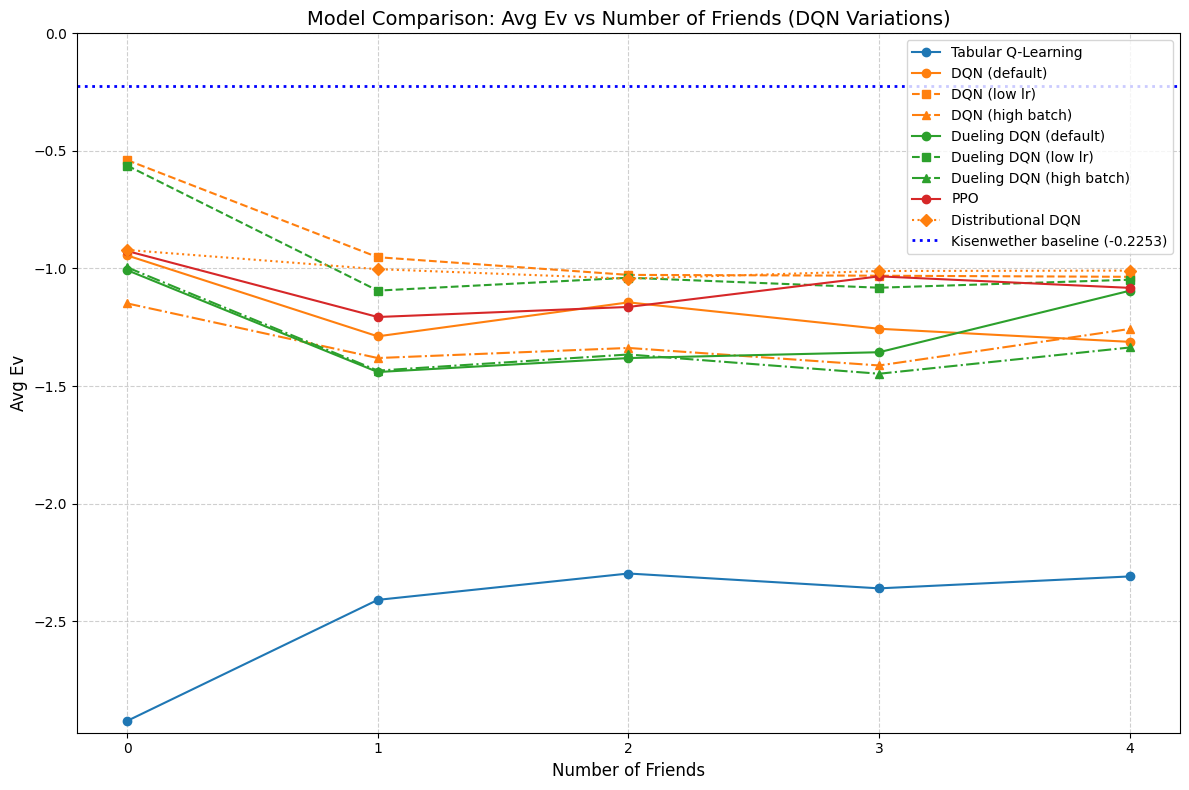

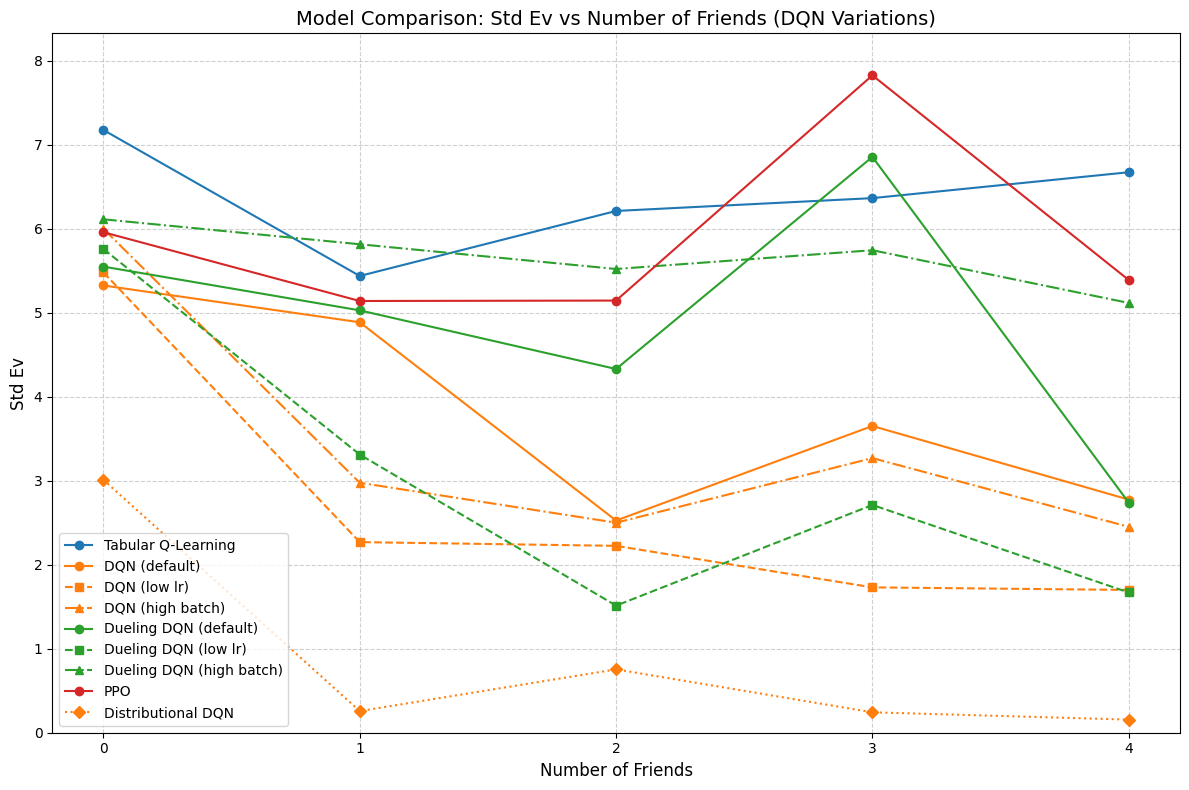

In [28]:
import matplotlib.pyplot as plt

# --- 1. Load saved performance results (no retraining) ---
with open("performance_results.json", "r") as f:
    perf = json.load(f)

# Friends range (JSON keys are strings)
FRIENDS_RANGE = sorted(int(k) for k in perf.keys())

# Model names from one friends entry
all_model_names = list(next(iter(perf.values())).keys())

# --- 2. Exclude Tabular Q-Learning V2 ---
PLOT_MODEL_NAMES = [
    name for name in all_model_names
    if name != "Tabular Q-Learning V2"
]

# Rebuild MODELS just for plotting (no AgentClass/params needed, but keep same structure)
MODELS = [(name, None, None) for name in PLOT_MODEL_NAMES]

# --- 3. ModelPlotStyler (copied from original, unchanged) ---
class ModelPlotStyler:
    def __init__(self, models):
        self.colors_map = plt.cm.get_cmap('tab10', len(models))  # Colormap for distinct colors
        self.linestyles = ['-', '--', '-.', ':']
        self.markers = ['o', 's', '^', 'D']  # Markers for variations
        self.reset()  # Initialize state

    def reset(self):
        """Resets the style tracking for a new plot."""
        self.model_family_style_idx = {}
        self.model_family_colors = {}
        self.current_color_idx = 0

    def get_style(self, model_name):
        """Returns color, linestyle, and marker for a given model name."""
        # Determine the base model family
        if "Tabular Q-Learning V2" in model_name:
            base_name = "Tabular Q-Learning V2"
        elif "Tabular Q-Learning" in model_name:
            base_name = "Tabular Q-Learning"
        elif "DQN" in model_name and "Dueling" not in model_name:
            base_name = "DQN"
        elif "Dueling DQN" in model_name:
            base_name = "Dueling DQN"
        elif "PPO" in model_name:
            base_name = "PPO"
        elif "Distributional DQN" in model_name:
            base_name = "Distributional DQN"
        else:
            base_name = model_name

        # Assign a color to the base model family if not already assigned
        if base_name not in self.model_family_colors:
            self.model_family_colors[base_name] = self.colors_map(self.current_color_idx)
            self.current_color_idx += 1
            self.model_family_style_idx[base_name] = 0  # Initialize style index for this family

        # Get the color for the current model
        color = self.model_family_colors[base_name]

        # Get the linestyle and marker for the current variation
        style_idx = self.model_family_style_idx[base_name]
        linestyle = self.linestyles[style_idx % len(self.linestyles)]
        marker = self.markers[style_idx % len(self.markers)]
        self.model_family_style_idx[base_name] += 1  # Increment for the next variation

        return color, linestyle, marker

styler = ModelPlotStyler(MODELS)
KISEN_BASELINE_EV = -0.2253   # Hardcoded Mississippi Stud baseline EV

for metric in ["avg_ev", "std_ev"]:
    plt.figure(figsize=(12, 8))
    styler.reset()

    for name, _, _ in MODELS:
        color, linestyle, marker = styler.get_style(name)
        ys = [
            perf[str(friends)][name][metric]
            for friends in FRIENDS_RANGE
        ]
        plt.plot(
            FRIENDS_RANGE,
            ys,
            marker=marker,
            label=name,
            color=color,
            linestyle=linestyle,
        )

    plt.xlabel("Number of Friends", fontsize=12)
    plt.ylabel(metric.replace("_", " ").title(), fontsize=12)
    plt.title(
        f"Model Comparison: {metric.replace('_', ' ').title()} vs Number of Friends (DQN Variations)",
        fontsize=14,
    )

    # ============================
    # CUSTOM Y-AXIS + BASELINE LOGIC
    # ============================
    if metric == "avg_ev":
        # Plot baseline line
        plt.axhline(
            KISEN_BASELINE_EV,
            linestyle=":",
            color="blue",
            linewidth=2,
            label=f"Kisenwether baseline ({KISEN_BASELINE_EV})"
        )

        # y-axis max = 0
        ymax = 0

        # y-axis minimum: min of (model EVs and baseline)
        all_evs = []
        for name, _, _ in MODELS:
            all_evs.extend([perf[str(f)][name]["avg_ev"] for f in FRIENDS_RANGE])
        all_evs.append(KISEN_BASELINE_EV)

        ymin = min(all_evs) - 0.05  # small padding

        plt.ylim(ymin, ymax)

    if metric == "std_ev":
        # Force y-axis minimum to 0
        all_stds = []
        for name, _, _ in MODELS:
            all_stds.extend([perf[str(f)][name]["std_ev"] for f in FRIENDS_RANGE])
        ymax = max(all_stds) + 0.5

        plt.ylim(0, ymax)

    # ============================

    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.xticks(FRIENDS_RANGE)
    plt.tight_layout()
    plt.show()
